<a href="https://colab.research.google.com/github/reinaldoasf/COVID-19/blob/master/Carla_Rede.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto Final
Identificação Raio X de pessoas com Covid-19


## Separando Conjuntos de Teste e Treino

Neste notebook terá o código necessário para ler as imagens do dataset de raios X do pulmão.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)
%cd /gdrive/My\ Drive/Kaggle

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1YSZg0Et9SrBuc91EBiHqhCI6Q8lKQ6YD/Kaggle


In [ ]:
!ls COVID-19/

 COVID-19		  NORMAL.metadata.xlsx	'Viral Pneumonia.matadata.xlsx'
 COVID-19.metadata.xlsx   README.md.txt
 NORMAL			 'Viral Pneumonia'


In [ ]:


import cv2
import os, glob
from PIL import Image, ImageOps
import numpy as np
import seaborn as sns
from imutils import paths
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, make_scorer
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, Xception
from tensorflow.keras import layers


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
LR = 0.001
EPOCHS = 20
BATCH_SIZE = 32
COVID_LEN = len(glob.glob("COVID-19/COVID-19/*"))
INP_SIZE = (224,224,3)
def create_data(dir_name):
    temp_data = []
    img_list = glob.glob(dir_name + '/*')
    for img in img_list:
        image = Image.open(img).resize((32, 32))
        #Tive que mudar o tamanho pq tava estourando a memória RAM do Colab
        image = ImageOps.grayscale(image=image)
        image = np.array(image)
        temp_data.append(image)
    return temp_data

data = []
labels = []

covid_dir = 'COVID-19/COVID-19'
normal_dir = 'COVID-19/NORMAL'
# pneumonia_dir = 'input/covid19-radiography-database/COVID-19 Radiography Database/Viral Pneumonia'

data.extend(create_data(covid_dir))
data.extend(create_data(normal_dir))
# data.extend(create_data(pneumonia_dir))


In [ ]:
# data = np.array(data)/255.0
labels = [1 if i < COVID_LEN else 0 for i in range(len(data))]
# labels_array = np.array(labels)
data_array = np.array(data)
# print(data_array.shape)
# print(labels_array.shape)
# print(labels_array)
# print(labels)

In [ ]:
# Deixar Y com uma dimensão apenas
labels_array = np.array(labels)

print(labels_array.shape)
print(labels_array[0])
(x_images_train, x_images_test, y_labels_train, y_labels_test) = train_test_split(
    data_array,
    labels_array,
    test_size=0.30,
    stratify=labels_array,
    random_state=42
)
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest"
)


(1560,)
1


In [ ]:
len(data)

1560

## Implementação da rede


In [ ]:
# models.sequential cria um grupo de camadas onde cada camada possui exatamente
# um tensor de entrada e um tensor de saida, agrupa uma pilha linear de camadas
model = Sequential()
input_shape_test=(32,32,1)
model.add(layers.Conv2D(32, (3, 3), input_shape=input_shape_test))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                460864    
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 130       
Total params: 461,314
Trainable params: 461,314
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Normalização
x_images_train, x_images_test = x_images_train / 255.0, x_images_test / 255.0

# Acrescentar 'uma dimensão' no X 
x_train_reshape = x_images_train
x_test_reshape = x_images_test
x_train_reshape = x_train_reshape.reshape(list(x_train_reshape.shape) + [1]) 
x_test_reshape  = x_test_reshape.reshape(list(x_test_reshape.shape) + [1]) 
# print(y_labels_test)
history = model.fit(x_train_reshape, y_labels_train, epochs=10, validation_data=(x_test_reshape, y_labels_test))

[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0
 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
Epoch 1/10
35/35 [==============================] 

## Analise da Rede


15/15 - 0s - loss: 0.0398 - accuracy: 0.9893


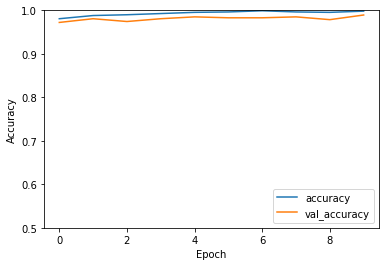

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test_reshape,  y_labels_test, verbose=2)

A acurácia do modelo do item a é de 0.9893162393162394
              precision    recall  f1-score   support

           0     0.9926    0.9950    0.9938       402
           1     0.9692    0.9545    0.9618        66

    accuracy                         0.9893       468
   macro avg     0.9809    0.9748    0.9778       468
weighted avg     0.9893    0.9893    0.9893       468

None


Text(0.5, 1.0, 'Matriz de confusão modelo CNN')

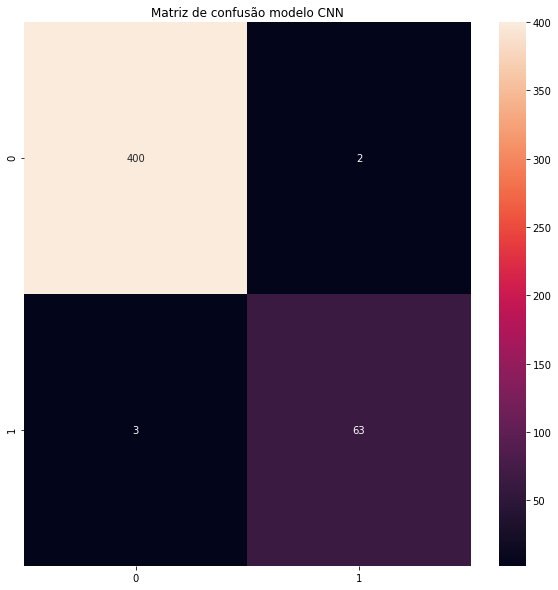

In [ ]:
predict = model.predict_classes(x_test_reshape,1)
#predict = np.around(predict)
class_names = ['Com covid', 'Sem covid']
conf_mat = confusion_matrix(y_labels_test, predict)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(conf_mat, annot=True, fmt=".0f")
print(f"A acurácia do modelo do item a é de {accuracy_score(y_labels_test, predict)}")
print(print(classification_report(y_labels_test, predict, digits=4)))
ax.set_title("Matriz de confusão modelo CNN")
# plt.xticks(np.arange(2), class_names)
# plt.yticks(np.arange(2), class_names)